In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict


import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import sklearn
from sklearn.model_selection import train_test_split

In [4]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x = train_df.iloc[:,1:].values
y = train_df['label'].values

In [6]:
print("X shape : {}".format(x.shape))
print("Y shape : {}".format(y.shape))

X shape : (42000, 784)
Y shape : (42000,)


* Split Train set / Validation set

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15)

In [8]:
print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("x_val shape : {}".format(x_val.shape))
print("y_val shape : {}".format(y_val.shape))

x_train shape : (35700, 784)
y_train shape : (35700,)
x_val shape : (6300, 784)
y_val shape : (6300,)


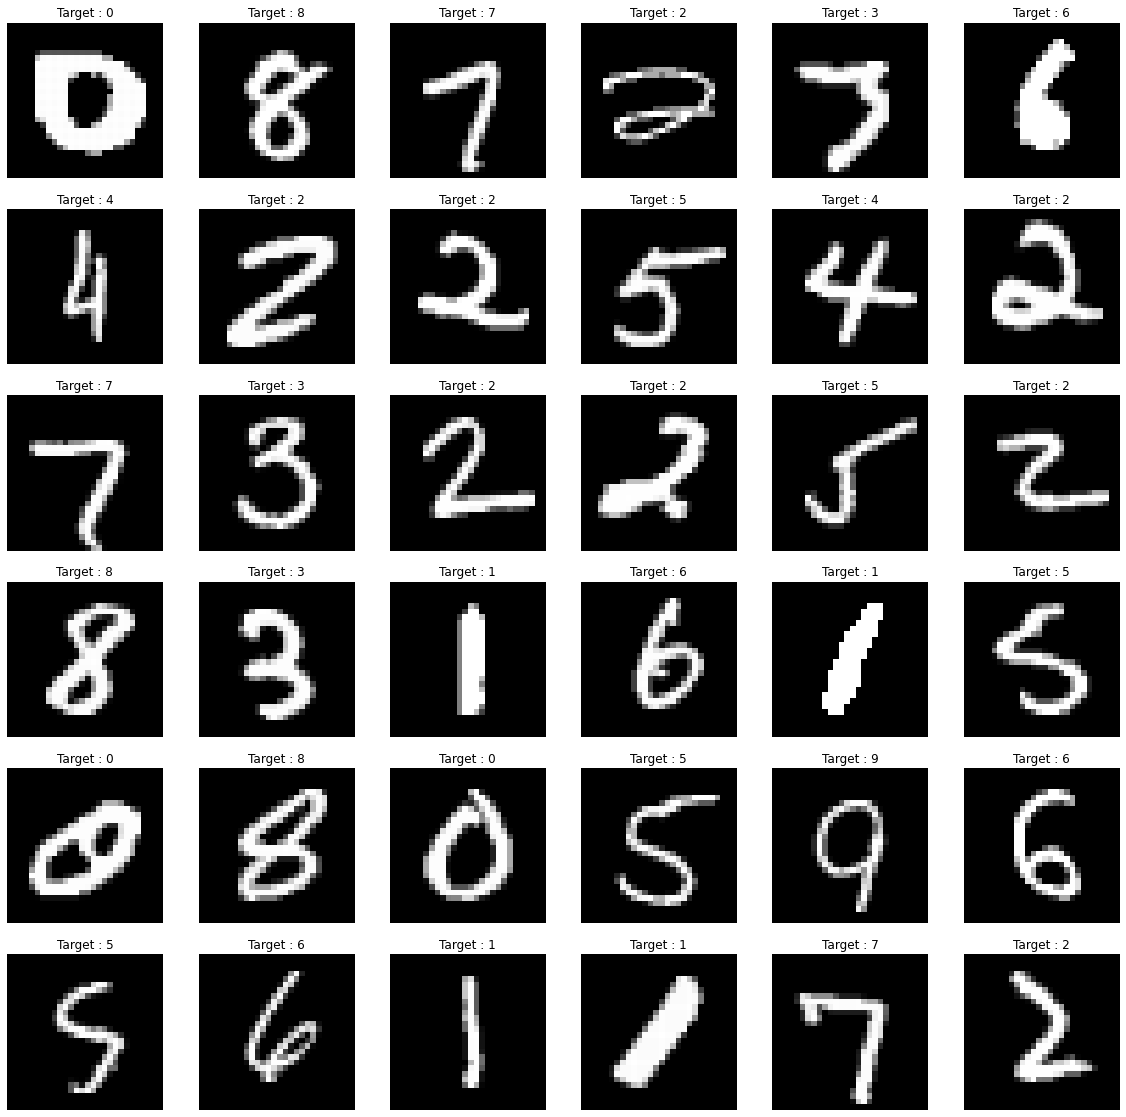

In [9]:
fig , axes = plt.subplots(6, 6, figsize=(20,20))

x_idx = 0
y_idx = 0

for i in range(6*6):
    if x_idx == 6:
        x_idx = 0
        y_idx += 1
        
    axes[y_idx][x_idx].imshow(x_train[i].reshape(28,28), 'gray')
    axes[y_idx][x_idx].axis("off")
    axes[y_idx][x_idx].set_title("Target : " + str(y_train[i]))
    x_idx += 1

plt.show()

1) as type to float 32 / int 64
2) is label
3) 

In [10]:
class BasicDataset(torch.utils.data.Dataset):
    def __init__(self,x_data, y_data=None):
        self.x = self.get_float_type(x_data)
        self.y = self.get_long_type(y_data)
        
        
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, index):
        global data
        data = {}
        
        x_row = self.x[index]
        data['data'] = x_row
    
        if self.y[index] != None: 
            y_row = self.y[index]
            data['target'] = y_row
            
        return data
    
        
    def get_float_type(self, data):
        data = data.astype('float32')
        data /= 255
        data = data.reshape(-1, 1, 28, 28)
        return data
    
    def get_long_type(self, target):
        target = target.astype(torch.LongTensor)
        return target

In [11]:
train_dataset = BasicDataset(x_train, y_train)
val_dataset = BasicDataset(x_val, y_val)

In [12]:
print("Data of train dataset : {}".format(train_dataset[0]['data']))
print("Target of train dataset : {}".format(train_dataset[0]['target']))

Data of train dataset : [[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0. 

In [13]:
BATCH_SIZE = 100

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [15]:
dataloaders_dict = {"train": train_loader, "val": val_loader}

In [16]:
class BasicCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output):
        super(BasicCNN, self).__init__()
        
        self.convolution_layer = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim_1, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(hidden_dim_1, hidden_dim_2, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2,2)    
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(1600, output),
            nn.Softmax()
        )
    
    def forward(self,x):
        out = self.convolution_layer(x)
        out = out.view(out.size(0),-1)
        out = self.fc_layer(out)
        return out

In [17]:
INPUT_DIM = 1
HIDDEN_DIM_1 = 32
HIDDEN_DIM_2 = 64
OUTPUT = 10

In [18]:
model = BasicCNN(INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, OUTPUT)

In [19]:
print("총 배치의 수 : {}".format(len(train_loader)))

총 배치의 수 : 357


In [20]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('A device that proceeds with : ',device)

True
A device that proceeds with :  cuda:0


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
def train_model(model, dataloaders_dict, loss_fn, optimizer, num_epochs, filename):
    model.to(device)

    history ={'train_loss' : [],
             'train_acc' : [],
              'val_loss' : [],
              'val_acc' : []
             }
    
    for epoch in range(num_epochs):
        for i, phase in enumerate(['train','val']):
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            correct = 0
            epoch_loss = 0
            epoch_acc = 0 

            for data in dataloaders_dict[phase]:
                x_data = data['data'].to(device)
                y_data = data['target'].to(device)

                optimizer.zero_grad()

                # 연산 추적
                predict = model(x_data)
                target = y_data
                loss = loss_fn(predict, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item() * len(x_data)
                correct += (target==predict.argmax(axis=1)).sum()
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = 100 * (correct / len(dataloaders_dict[phase].dataset))
            print("{} : [{} / {}] Loss : {:.4f}  | Accuracy : {:.2f}%".format(phase.upper(), epoch+1, num_epochs, epoch_loss, epoch_acc))
            
            history['{}_loss'.format(phase)].append(epoch_loss)
            history['{}_acc'.format(phase)].append(epoch_acc)
        print(" ")
    return history

In [23]:
NUM_EPOCHS = 50
SAVE_MODEL_PATH = f'cnn.pth'

In [24]:
history = train_model(
    model,
    dataloaders_dict,
    loss_fn, 
    optimizer,
    NUM_EPOCHS,
    SAVE_MODEL_PATH
    )

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


TRAIN : [1 / 50] Loss : 1.8994  | Accuracy : 55.76%
VAL : [1 / 50] Loss : 1.7702  | Accuracy : 68.90%
 
TRAIN : [2 / 50] Loss : 1.7437  | Accuracy : 71.55%
VAL : [2 / 50] Loss : 1.6808  | Accuracy : 77.95%
 
TRAIN : [3 / 50] Loss : 1.6755  | Accuracy : 78.48%
VAL : [3 / 50] Loss : 1.6764  | Accuracy : 78.35%
 
TRAIN : [4 / 50] Loss : 1.6756  | Accuracy : 78.51%
VAL : [4 / 50] Loss : 1.6755  | Accuracy : 78.49%
 
TRAIN : [5 / 50] Loss : 1.6750  | Accuracy : 78.57%
VAL : [5 / 50] Loss : 1.6809  | Accuracy : 78.02%
 
TRAIN : [6 / 50] Loss : 1.6759  | Accuracy : 78.49%
VAL : [6 / 50] Loss : 1.6758  | Accuracy : 78.52%
 
TRAIN : [7 / 50] Loss : 1.6749  | Accuracy : 78.59%
VAL : [7 / 50] Loss : 1.6813  | Accuracy : 77.97%
 
TRAIN : [8 / 50] Loss : 1.6745  | Accuracy : 78.65%
VAL : [8 / 50] Loss : 1.6752  | Accuracy : 78.59%
 
TRAIN : [9 / 50] Loss : 1.6764  | Accuracy : 78.45%
VAL : [9 / 50] Loss : 1.6731  | Accuracy : 78.79%
 
TRAIN : [10 / 50] Loss : 1.6767  | Accuracy : 78.43%
VAL : [10 /

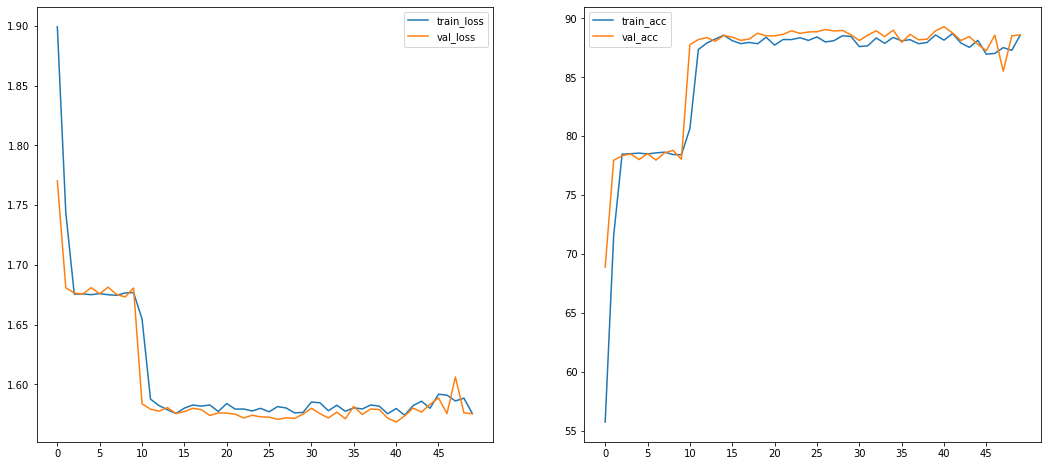

In [25]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
axes[0].plot(history['train_loss'],label='train_loss')
axes[0].plot(history['val_loss'], label='val_loss')
axes[0].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[0].legend()


axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['val_acc'], label='val_acc')
axes[1].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[1].legend()

plt.show()